In [ ]:
!pip install tifffile > /dev/null
!pip install imagecodecs > /dev/null
!pip install torchstain > /dev/null

In [1]:
import cv2
import torch
import tifffile
import torchstain
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from torchvision import transforms

In [2]:
%matplotlib inline

In [3]:
wsl_image = tifffile.imread("data/patient_192_node_3.tif")

In [4]:
wsl_image.shape

(60928, 77824, 3)

## WSL Visualization

Visualize the WSL by splitting it into 100 images, each being 7782x6092 pixels wide.

In [5]:
slices_blocks = 50

In [6]:
single_image_height = wsl_image.shape[1] // slices_blocks
single_image_width = wsl_image.shape[0] // slices_blocks

single_image_height, single_image_width

(1556, 1218)

In [7]:
y_offset_cells = 7
y_offset = single_image_height * y_offset_cells

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 12.77it/s]


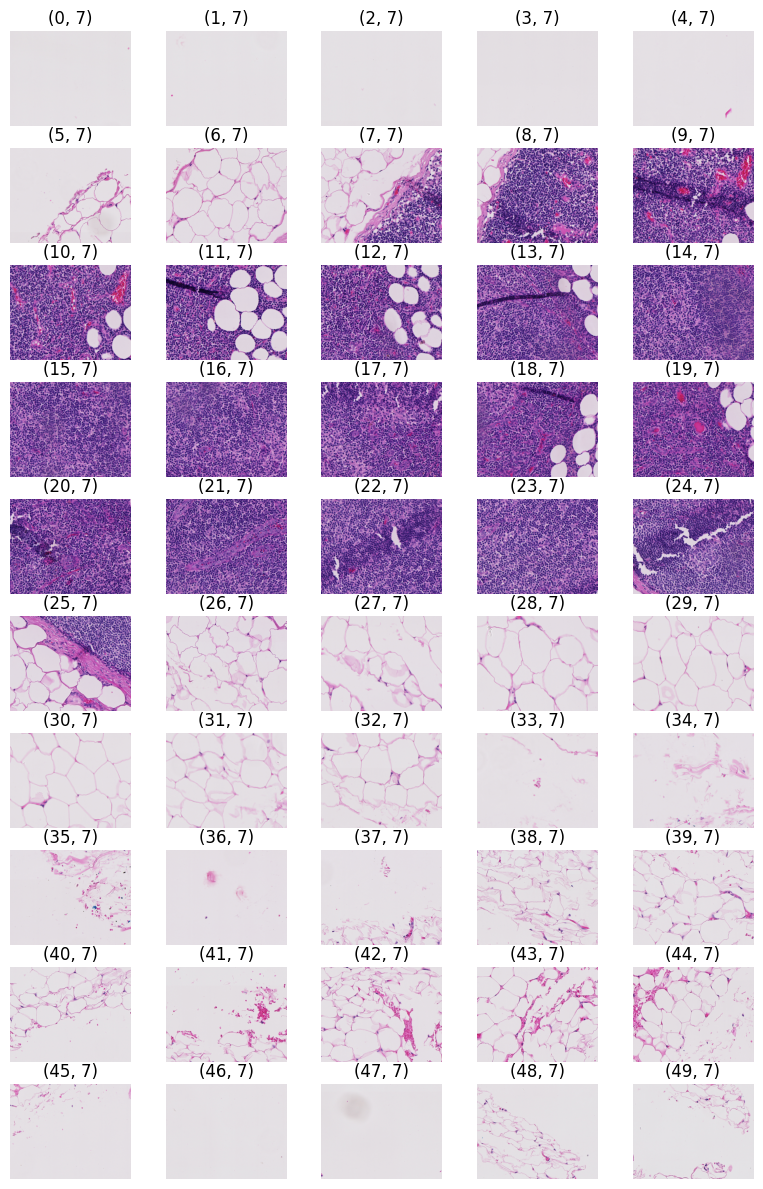

In [8]:
fig, axes = plt.subplots(slices_blocks // 5, 5, figsize=(8, 12))
axes = axes.reshape(np.prod(axes.shape))

for i in tqdm(range(len(axes))):
    ax = axes[i]
    ax.axis("off")
    ax.set_title(f"({i}, {y_offset_cells})")

    start_h = single_image_width * i
    end_h = single_image_width * (i + 1)

    ax_image = wsl_image[start_h:end_h, y_offset:(y_offset + single_image_height), :]
    ax.imshow(ax_image)

plt.tight_layout(h_pad=0)
plt.show()

In [9]:
def get_wsl_slice(x: int, y: int):
    return wsl_image[
        (single_image_width * x):(single_image_width * (x + 1)),
        (single_image_height * y):(single_image_height * (y + 1)),
        :
    ]

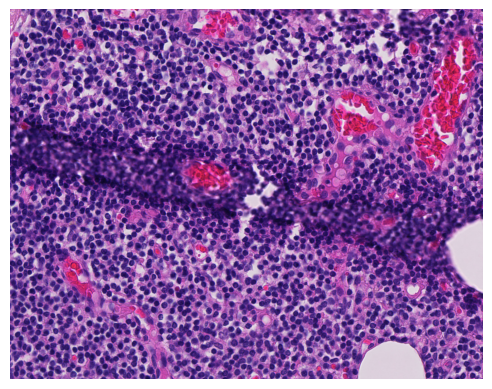

In [10]:
# Show a single arbitrary image
x, y = 9, 7
selected_image = get_wsl_slice(x=x, y=y)

plt.axis("off")
plt.imshow(selected_image)

In [11]:
tifffile.imwrite("data/target.tif", selected_image)

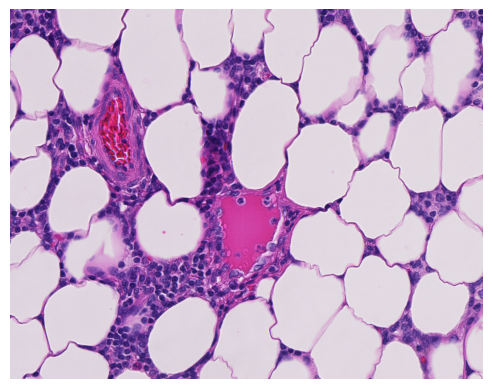

In [12]:
target = get_wsl_slice(x=18, y=8)

plt.axis("off")
plt.imshow(target)

## Macenko Normalization

In [13]:
baseline = cv2.cvtColor(cv2.imread("stain_normalization_target.tif"), cv2.COLOR_BGR2RGB)

In [14]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 255)
])

In [15]:
normalizer = torchstain.normalizers.MacenkoNormalizer(backend="torch")
normalizer.fit(data_transform(baseline))

In [16]:
target_tensor = data_transform(target)

In [17]:
norm, H, E = normalizer.normalize(
    I=target_tensor,
    stains=True
)

Text(0.5, 1.0, 'E')

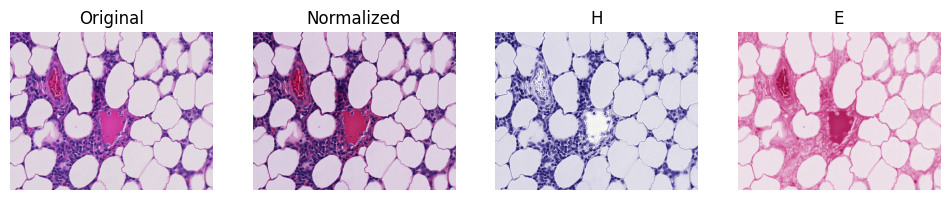

In [18]:
fig, axes = plt.subplots(1, 4, figsize=(12, 5))

for ax in axes:
    ax.axis("off")

axes[0].imshow(target)
axes[0].set_title("Original")

axes[1].imshow(norm)
axes[1].set_title("Normalized")

axes[2].imshow(H)
axes[2].set_title("H")

axes[3].imshow(E)
axes[3].set_title("E")

### Try to normalize some dataset samples

In [19]:
from src.enums import PatchCamelyonSplit
from src.datasets.loaders import get_data_loader

In [20]:
train_loader = get_data_loader(
    split=PatchCamelyonSplit.TRAIN,
    batch_size=1,
    shuffle=False
)

dataset = train_loader.dataset

In [21]:
n_samples = 10

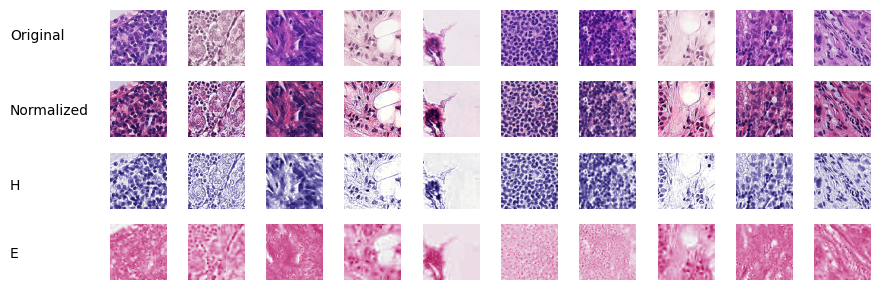

In [22]:
fig, axes = plt.subplots(4, 10, figsize=(8, 3))

fig.text(-0.1, 0.85, "Original")
fig.text(-0.1, 0.6, "Normalized")
fig.text(-0.1, 0.35, "H")
fig.text(-0.1, 0.125, "E")

for i in range(10):
    regular_ax = axes[0, i]
    normalized_ax = axes[1, i]
    H_ax, E_ax = axes[2, i], axes[3, i]

    image, _ = dataset[i]
    int_image = (image.permute(1, 2, 0) * 255).to(torch.uint8)
    normalized_image, norm_H, norm_E = normalizer.normalize(
        I=data_transform(int_image.numpy()),
        stains=True
    )

    for ax in axes[:, i].reshape(4):
        ax.axis("off")

    regular_ax.imshow(int_image)
    normalized_ax.imshow(normalized_image)

    H_ax.imshow(norm_H)
    E_ax.imshow(norm_E)

plt.tight_layout()
plt.show()